# Description
This notebook prepares a pair plot of the cultivation model posterior, together with a timeseries density.

In [7]:
import numpy
import arviz
from arviz.labels import MapLabeller
import fastprogress
import json
import time
import pymc3
import pandas
import pathlib
from matplotlib import cm, pyplot, image
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition

import murefi
import calibr8

import models
import plotting

DP_FIGURES = pathlib.Path("figures")
DP_PROCESSED = pathlib.Path("processed")

In [2]:
cm_biomass = models.get_biomass_model()
cm_glucose = models.get_glucose_model()
model = models.MonodModel()
dataset = murefi.load_dataset(DP_PROCESSED / "cultivation_dataset.h5")
idata_full = arviz.from_netcdf(DP_PROCESSED / "full_posterior.nc")

### Make a pair plot of the entire posterior

Plotting time: 76 seconds.
Saving time: 0 seconds.


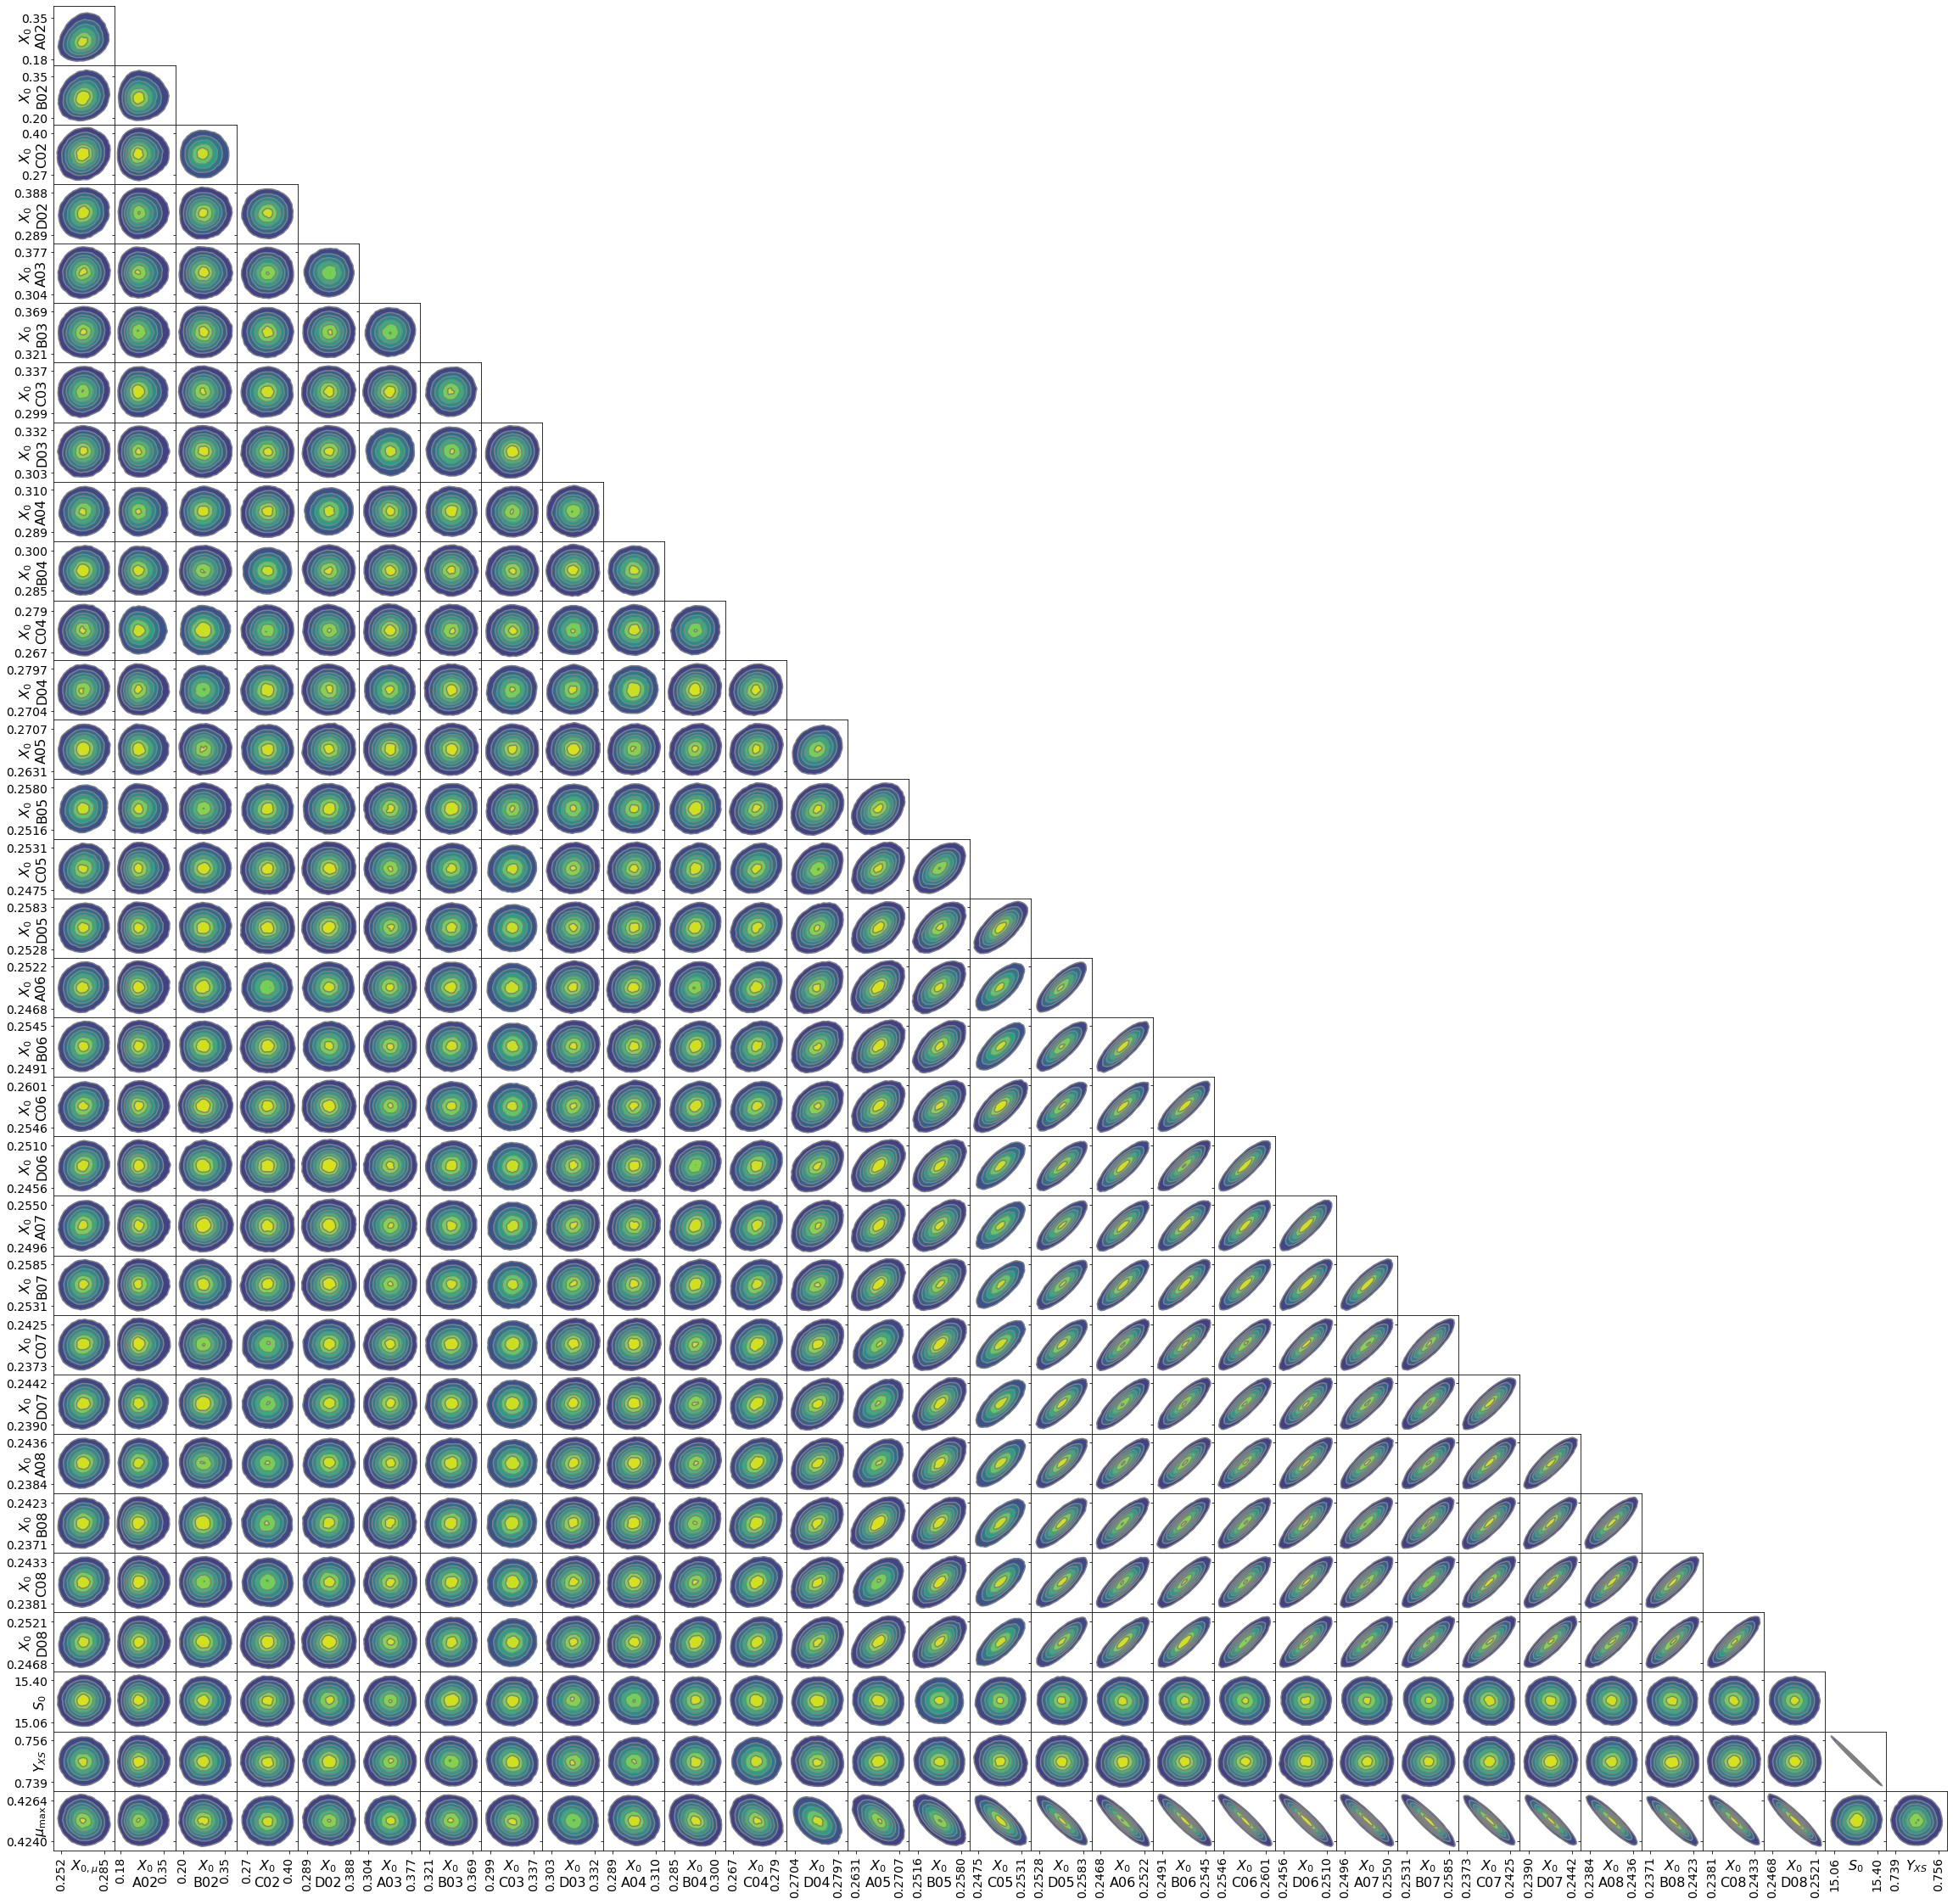

In [14]:
def hdi_ticklimits(axs, idata, replacements, ylabelpad=-50, xlabelpad=-15, xrotate=False):
    posterior = idata.posterior.stack(sample=("chain", "draw"))
    hdi90 = arviz.hdi(idata, hdi_prob=0.9)
    hdi98 = arviz.hdi(idata, hdi_prob=0.98)
    inv_replacements = {val: key for key, val in replacements.items()}
    def _edit(axs, which: str):
        get_label = getattr(axs[0], f"get_{which}label")
    
        label = get_label()
        rvname = label.split("\n")[0]
        rvname = inv_replacements.get(rvname, rvname)
        rv = posterior[rvname]
        sel = {}
        if "\n" in label:
            for cname, cval in zip(rv.coords, label.split("\n")[1:]):
                # TODO: typecast cval to match the coord type
                sel[cname] = cval
        limits = hdi98[rvname].sel(sel).values
        hdi = hdi90[rvname].sel(sel).values
        # Round the HDI such that it differs in the last 2 decimals.
        # This way the label looks nice but is only positioned wrong by <1%
        # of the plot width.
        sigdigits = max(0, numpy.ceil(numpy.log10(1 / numpy.abs(hdi[1] - hdi[0]))) + 1)
        hdi = numpy.round(hdi, decimals=int(sigdigits))
        for i, ax in enumerate(axs):
            if i == 0:
                get_label = getattr(ax, f"get_{which}label")
                set_label = getattr(ax, f"set_{which}label")
                set_label(get_label(), labelpad=ylabelpad if which == "y" else xlabelpad)
            ax.set(**{f"{which}lim": limits, f"{which}ticks": hdi})
            if xrotate and which == "x":
                ax.tick_params("x", labelrotation=90)

    for r, axr in enumerate(axs[:]):
        _edit(axr, which="y")
    for c, axc in enumerate(axs[:, :].T):
        _edit(axc[::-1], which="x")
    # move labels back
    fig = pyplot.gcf()
    fig.align_ylabels()
    fig.align_xlabels()
    return

arviz.rcParams["plot.max_subplots"] = 1000

t_start = time.time()

replacements = {
    "F_offset": "$F_{offset}$",
    "X0_mu": "$X_{0,\mu}$",
    "X0": "$X_{0}$",
    "S0": "$S_{0}$",
    "mu_max": "$\mu_{\max}$",
    "Y_XS": "$Y_{XS}$"
}
labeller = MapLabeller(var_name_map=replacements)

axs = arviz.plot_pair(
    idata_full,
    var_names=["~F_offset"],
    figsize=(40, 40),
    coords=dict(replicate=idata_full.posterior.replicate.values.reshape(4, 7).flatten("F")),
    kind='kde',
    labeller=labeller,
    backend_kwargs=dict(gridspec_kw=dict(hspace=0, wspace=0))
)

hdi_ticklimits(axs, idata_full, replacements, xlabelpad=-47, xrotate=True)
t_end = time.time()
print(f"Plotting time: {t_end - t_start:.0f} seconds.")
#plotting.savefig(fig, "Appendix_pairplot", dpi=200, bbox_inches="tight")
print(f"Saving time: {time.time() - t_end:.0f} seconds.")
pyplot.show()

### Prepare a plot of timeseries densities for a subset of the replicates

In [4]:
subset = {
    'D04': dataset['D04'],
    'D06': dataset['D06']
}
theta_mapping = models.get_parameter_mapping(rids=subset.keys())

In [5]:
inferred_posteriors = {}
for r, (rid, replicate) in enumerate(subset.items()):
    ts = replicate['Pahpshmir_1400_BS3_CgWT']
    for i, (t, y) in fastprogress.progress_bar(list(enumerate(zip(ts.t, ts.y)))):
        inferred_posteriors[(rid, i)] = cm_biomass.infer_independent(y, lower=0, upper=20, ci_prob=0.9)

e:\share2\calibr8\calibr8\core.py:708: RuntimeWarning: divide by zero encountered in log10
  y = (numpy.exp(s2 * (s3 * (log_I_x - numpy.log10(x)) + c / s2)) + 1) ** -s1
e:\share2\calibr8\calibr8\core.py:708: RuntimeWarning: invalid value encountered in log10
  y = (numpy.exp(s2 * (s3 * (log_I_x - numpy.log10(x)) + c / s2)) + 1) ** -s1


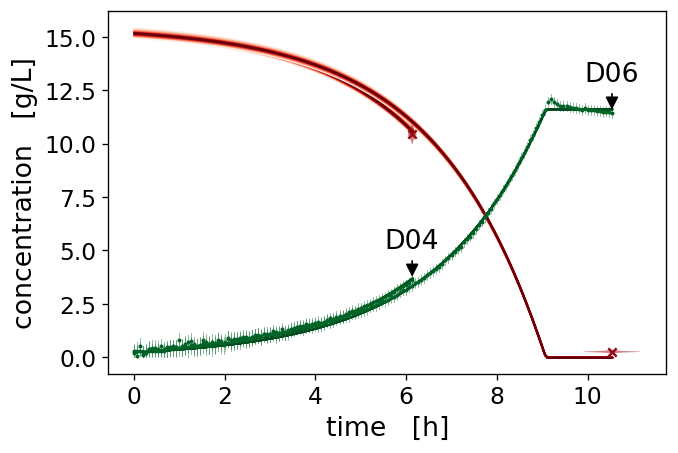

In [6]:
def plot_kinetics(ax):
    parameters_sample = plotting.extract_parameters(idata_full, theta_mapping, nmax=1000)

    ds_prediction = model.predict_dataset(
        template=murefi.Dataset.make_template_like(subset, independent_keys='SX'),
        parameter_mapping=theta_mapping,
        parameters=parameters_sample
    )

    red = cm.Reds(0.9)
    green = cm.Greens(0.9)

    for rid, rep in ds_prediction.items():
        for ikey, ts in rep.items():
            pymc3.gp.util.plot_gp_dist(
                ax=ax,
                x=ts.t,
                samples=ts.y,
                palette='Reds' if ikey == 'S' else 'Greens',
                plot_samples=False
            )

    for r, (rid, replicate) in enumerate(subset.items()):
        # biomass
        ts = replicate['Pahpshmir_1400_BS3_CgWT']
        ax.scatter(ts.t, cm_biomass.predict_independent(ts.y), s=2, color=green)
        for i, (t, y) in fastprogress.progress_bar(list(enumerate(zip(ts.t, ts.y)))):
            pst = inferred_posteriors[(rid, i)]
            ax.plot(
                [t, t],
                [pst.hdi_lower, pst.hdi_upper],
                color=green, alpha=0.5, linewidth=0.5
            )

        # glucose
        ts = replicate['A365']
        ax.scatter(ts.t, cm_glucose.predict_independent(ts.y), s=25, color=red, marker='x')
        pst = cm_glucose.infer_independent(ts.y, lower=0, upper=20, ci_prob=0.9)
        ax.fill_betweenx(
            y=pst.hdi_x,
            x1=ts.t - pst.hdi_pdf/20,
            x2=ts.t + pst.hdi_pdf/20,
            color=red, alpha=0.5,
            edgecolor=None,
        )
        # annotations
    for rid, replicate in subset.items():
        x = replicate['Pahpshmir_1400_BS3_CgWT'].t[-1]
        y = replicate['Pahpshmir_1400_BS3_CgWT'].y[-1]
        y = cm_biomass.predict_independent(replicate['Pahpshmir_1400_BS3_CgWT'].y[-1])
        
        if not numpy.isfinite(y):
            y = 0
        ax.annotate(
            rid, xy=(x, y), xytext=(x, y+1.5), 
            arrowprops=dict(arrowstyle='-|>', facecolor='black'),
            horizontalalignment='center',
        )

    ax.set_ylabel('concentration   [g/L]')
    ax.set_xlabel('time   [h]')
    
fig, ax = pyplot.subplots(dpi=120)
plot_kinetics(ax)
plotting.savefig(fig, '4.2.3 Pairplot and Kinetic Density')
pyplot.show()

### Combined figure

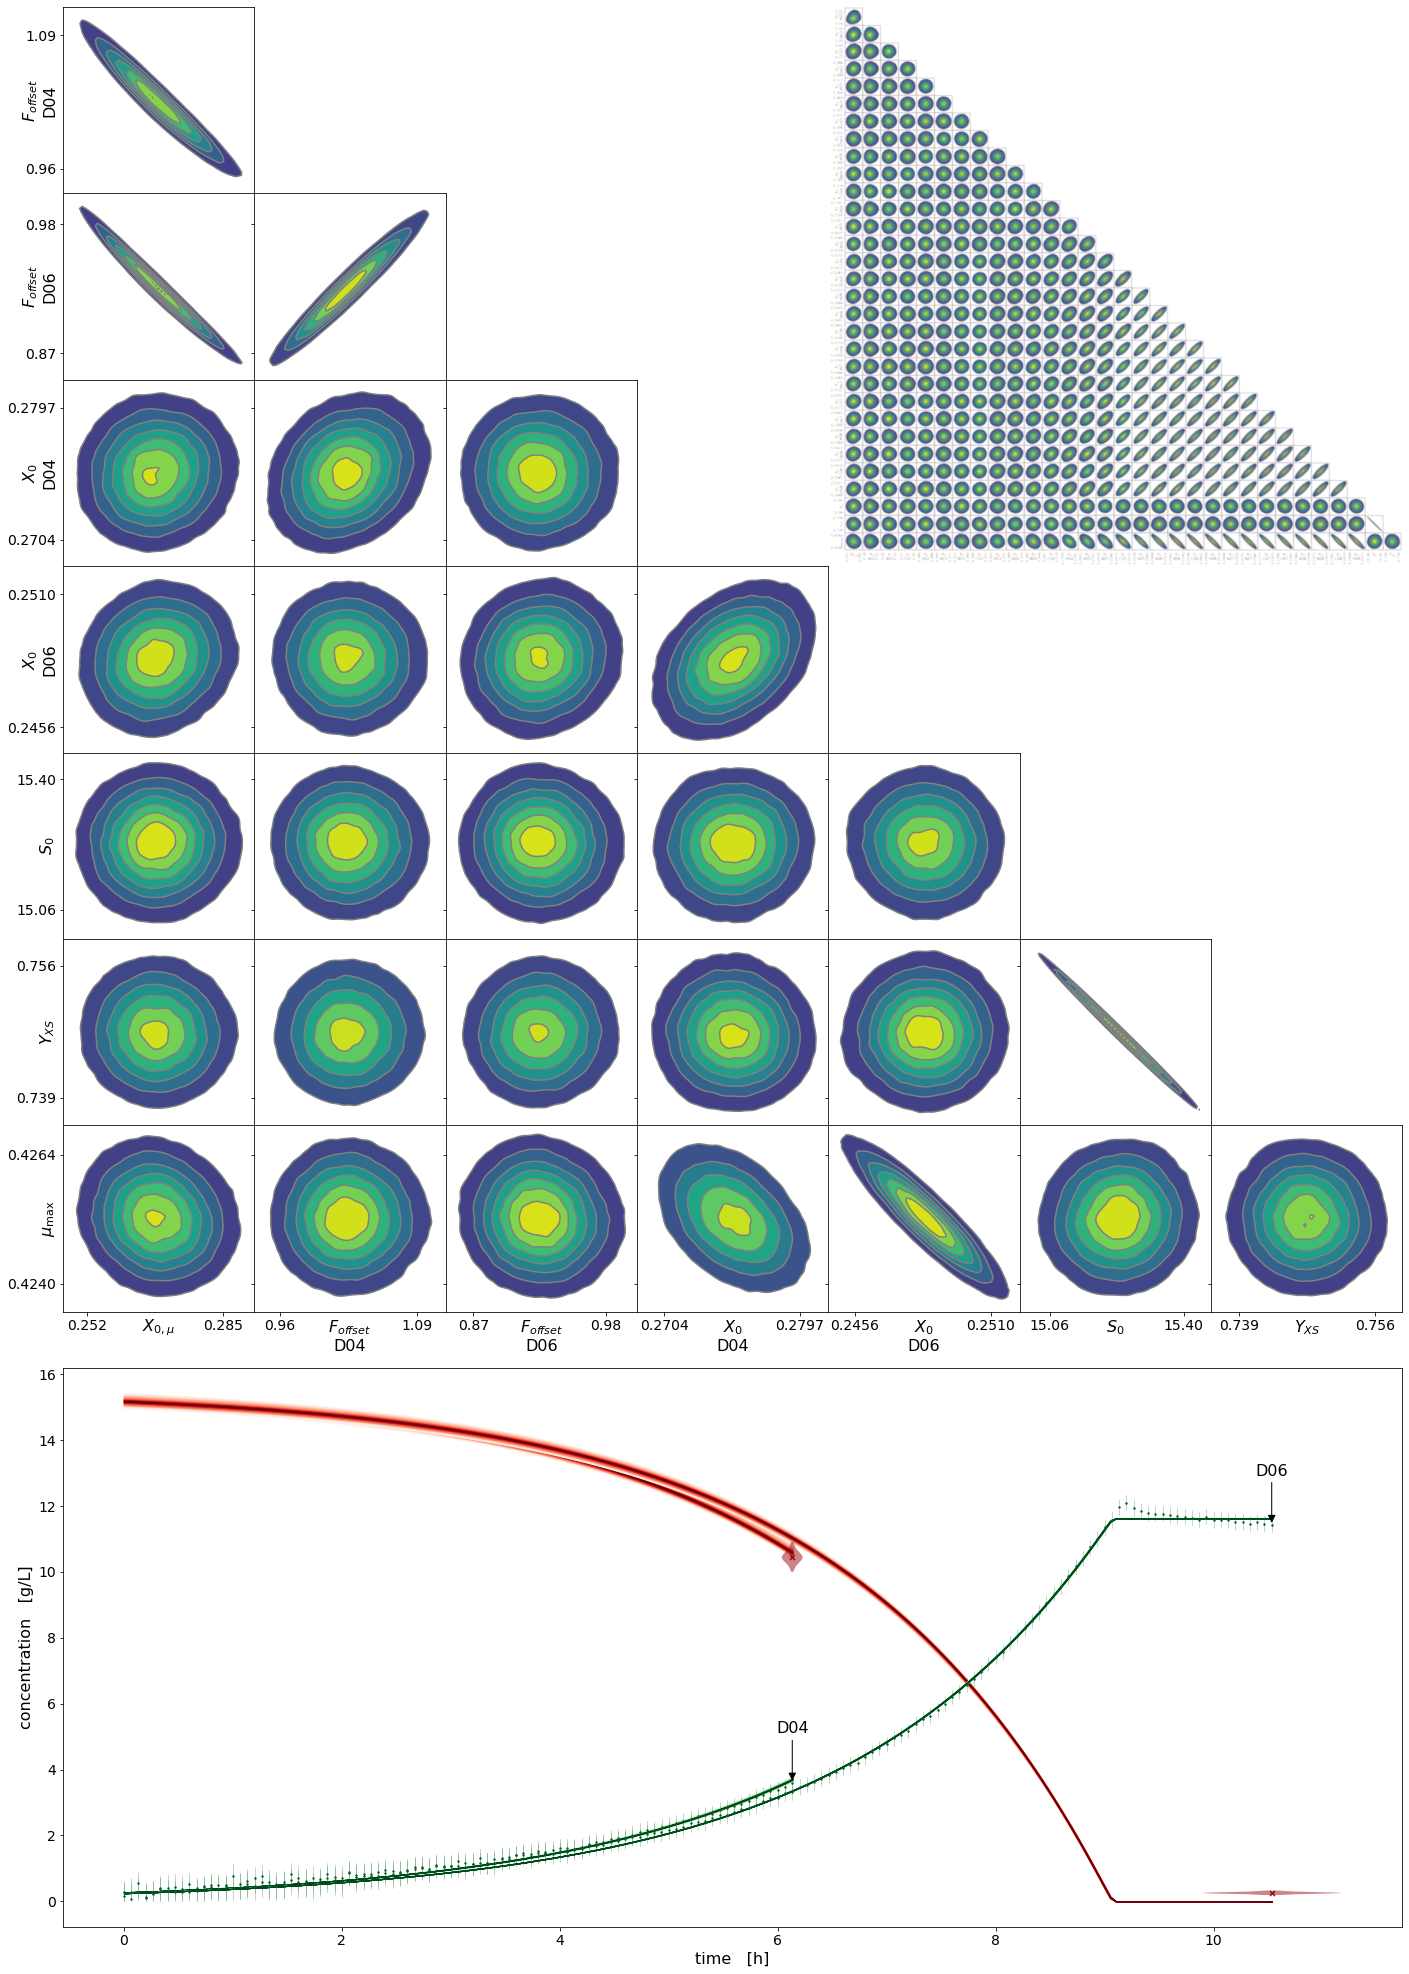

In [7]:
replacements = {
    "F_offset": "$F_{offset}$",
    "X0_mu": "$X_{0,\mu}$",
    "X0": "$X_{0}$",
    "S0": "$S_{0}$",
    "mu_max": "$\mu_{\max}$",
    "Y_XS": "$Y_{XS}$"
}

axs = arviz.plot_pair(
    idata_full, 
    figsize=(24, 24),
    coords=dict(replicate=['D04', 'D06']),
    kind='kde',
)
nrows, ncols = axs.shape
fig = pyplot.gcf()

# customize pairplot
hdi_ticklimits(axs, idata_full)
replace_labels(axs, replacements)
fig.subplots_adjust(hspace=0, wspace=0)

# add inset plot of full posterior
ax_inset = pyplot.axes([0,0,1,1])         # create a new subplot from [left, bottom, w, h]
ip = InsetPosition(axs[0,0], [4,-2,3,3])  # move it right down & scale it, relative to the top-left subplot
ax_inset.set_axes_locator(ip)
img = image.imread(DP_FIGURES / "Appendix_pairplot.png")
ax_inset.imshow(img[::-1,...], interpolation="bicubic")
ax_inset.set_axis_off()
#ax_inset.text(
#    x=0.5, y=-0.03, transform=ax_inset.transAxes,
#    s="high resolution in Appendix", horizontalalignment="center"
#)

# add another inset for the kinetic
h, w = 3, ncols
ax = pyplot.axes([0,0,w,h])                # can't use the same args as before (DeprecationWarning)
ax.set_axes_locator(InsetPosition(axs[-1,0], [0,-h-0.3,w,h]))  # this time to the bottom-left subplot
plot_kinetics(ax)
plotting.savefig(fig, "4.2.3 Pair plot and kinetics", dpi=150, bbox_inches="tight")
pyplot.show()

In [8]:
%load_ext watermark
%watermark

Last updated: 2021-05-10T19:50:32.547200+02:00

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.19.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 6
Architecture: 64bit

